In this notebook, we examine the best model found with `../src/models/quick_evaluation.py` by cross-validation.

In [1]:
import sys
sys.path.insert(0, "../src/data/")

import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

from data_generator import DataGenerator
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from statistics import mean, stdev
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
cores = multiprocessing.cpu_count()

Let's first define our model, this is `m10` from `../src/models/candidates.py`.

In [3]:
def create_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(512, 512, 1)))
    model.add(Conv2D(64, (6, 6), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

epochs = 10
callbacks = [EarlyStopping(monitor="val_loss", patience=2, mode="min", restore_best_weights=True)]
batch_size = 16

Then we'll load the data. We'll be doing a random stratified sample since training our model multiple times on the full dataset would take prohibitively long.
The sample size will be larger than all the tests done with `../src/models/quick_evaluation` ($100000$), however we are limiting ourselves to $10$ epochs.

In [4]:
ids = np.load("../data/processed/any_hemo_split/X_any_hemo_ids_train.npy", allow_pickle=True)
y = np.load("../data/processed/any_hemo_split/y_any_hemo_train.npy", allow_pickle=True)
_, ids, _, y = train_test_split(ids, y, test_size=100000/len(ids), stratify=y)
ids, ids_val, y, y_val = train_test_split(ids, y, test_size=0.2, stratify=y)

Now we can perform the cross-validation; we'll be doing this over $5$ folds.

In [5]:
histories = []
results = []
k_folds = enumerate(StratifiedKFold(5).split(ids, y))
for i, (train, test) in k_folds:
    print(f"Training fold {i+1}.")
    train_gen = DataGenerator(ids[train], y[train], "../data/processed/images", batch_size)
    val_gen = DataGenerator(ids_val, y_val, "../data/processed/images", batch_size)
    test_gen = DataGenerator(ids[test], y[test], "../data/processed/images", batch_size)
    class_weights = dict(enumerate(class_weight.compute_class_weight("balanced", np.unique(y[train]), y[train])))
    
    model = create_model()
    history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen, class_weight=class_weights, workers=cores)
    histories.append(history)

    y_pred = model.predict(test_gen) > 0.5

    f2 = fbeta_score(y[test], y_pred, 2)
    accuracy = accuracy_score(y[test], y_pred)
    recall = recall_score(y[test], y_pred)
    precision = precision_score(y[test], y_pred)

    results.append((f2, accuracy, recall, precision))

Training fold 1.
Epoch 1/10
4000/4000 [==============================] - 529s 132ms/step - loss: 0.5580 - accuracy: 0.6915 - val_loss: 0.5671 - val_accuracy: 0.7306
Epoch 2/10
4000/4000 [==============================] - 505s 126ms/step - loss: 0.4900 - accuracy: 0.7550 - val_loss: 0.4595 - val_accuracy: 0.7933
Epoch 3/10
4000/4000 [==============================] - 504s 126ms/step - loss: 0.4521 - accuracy: 0.7666 - val_loss: 0.4707 - val_accuracy: 0.7478
Epoch 4/10
4000/4000 [==============================] - 505s 126ms/step - loss: 0.4148 - accuracy: 0.7912 - val_loss: 0.5521 - val_accuracy: 0.6609
Training fold 2.
Epoch 1/10
4000/4000 [==============================] - 507s 127ms/step - loss: 0.5540 - accuracy: 0.6900 - val_loss: 0.5183 - val_accuracy: 0.7308
Epoch 2/10
4000/4000 [==============================] - 506s 127ms/step - loss: 0.4833 - accuracy: 0.7483 - val_loss: 0.4857 - val_accuracy: 0.7262
Epoch 3/10
4000/4000 [==============================] - 505s 126ms/step - loss

Great, let's examine the results.

In [6]:
f2s, accuracies, recalls, precisions = list(zip(*results))
print(f"Mean F2: {mean(f2s)} +/- {stdev(f2s)}")
print(f"Mean Accuracy: {mean(accuracies)} +/- {stdev(accuracies)}")
print(f"Mean Sensitivity: {mean(recalls)} +/- {stdev(recalls)}")
print(f"Mean Specificity: {mean(precisions)} +/- {stdev(precisions)}")

Mean F2: 0.49245483899622905 +/- 0.2315297197190879
Mean Accuracy: 0.794975 +/- 0.035344692184612406
Mean Sensitivity: 0.5807419804869361 +/- 0.29245583473413417
Mean Specificity: 0.36758271920939717 +/- 0.014978205457448827


Not bad at all. These are metrics that we're happy with, though the variance is still pretty high. That's to be expected with the number of samples each fold is getting. This just gives us a rough idea of performance.

Let's take a look at the individual loss curves to see if there's any last things to tweak before final training.

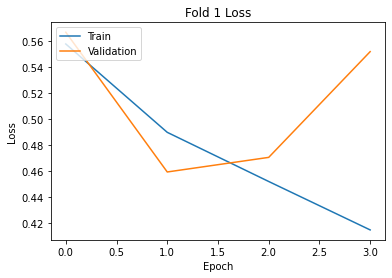

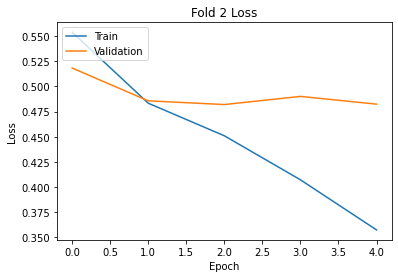

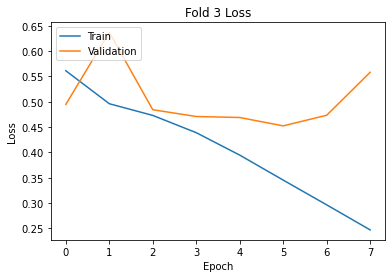

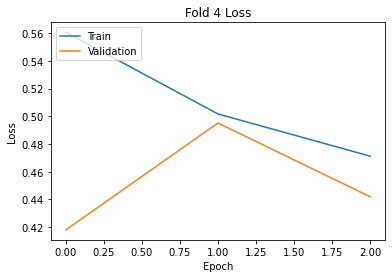

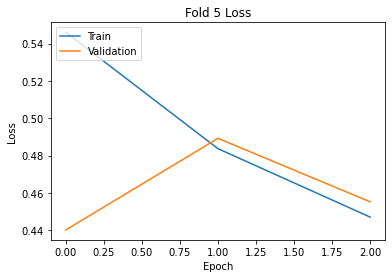

In [10]:
for i, history in enumerate(histories):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"Fold {i+1} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()
    plt.close()

These loss curves look pretty rough. The training curve looks great in every fold, but the validation curve seems to be unrepresentative. This will smooth out once we introduce more samples into the mix, and we'll also increase the patience for early stopping.